# GP regression with heteroscedasic noise
## Pyro implementation demo notebook

In [833]:
import torch
import pyro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import GP regression code
from importlib import reload
import dli_gpr

%matplotlib inline

## Loading input data

In [854]:
# read input data
test_fname = "v2_MetaclusterPE2_R_gprinput.txt"
test_df = pd.read_csv(test_fname, sep="\t", header=0)

# get rid of rows with NaN
test_df.dropna(inplace=True)

test_df

,time,proportion(y),numcellsincluster(x),totalcellsinsample(n),patientID,sampleID,tumorburden
0,-30,0.0061,1,329,DFCI-5310,1,94.0
1,180,0.2542,21,1310,DFCI-5310,2,0.0
2,-42,0.0109,127,2834,DFCI-5309,5,11.0
3,90,0.0094,88,2030,DFCI-5309,6,0.0
4,0,0.0773,7,3184,DFCI-5311,9,44.0
6,90,0.0181,32,3762,DFCI-5311,11,0.0
7,270,0.1923,24,8662,DFCI-5311,12,0.0
8,0,0.0560,116,1358,DFCI-5312,21,38.0
9,270,0.4615,1,13,DFCI-5312,22,0.0
10,-5,0.0997,10,1174,DFCI-5317,23,80.0


## Preparing model input

Below we prepare two models: one to describe tumor burden and one to describe the proportion of cells found in that metacluster.

In [862]:
# prepare torch tensor for time points
y = torch.FloatTensor(test_df.time.values)

# reponse variables (one for metclusters, one for tumor burden)
metacluster = torch.FloatTensor(test_df["proportion(y)"].values)
tumorburden = torch.FloatTensor(test_df["tumorburden"].values)

# number of cells size in each time point
cluster_sizes = torch.FloatTensor(test_df["totalcellsinsample(n)"].values)

## Model initialization and optimization

In [863]:
reload(dli_gpr)

# tumor burden model
tumor_model = dli_gpr.dli_gpr(y, tumorburden, cluster_sizes)

# metacluster model
metacluster_model = dli_gpr.dli_gpr(y, metacluster, cluster_sizes)

# initialize kernel and center the response variable
tumor_model.initialize_variables(jitter=1e-6)
metacluster_model.initialize_variables(jitter=1e-6)

### Optimize each model
We will run 2000 iterations of SVI for each model.

In [864]:
pyro.clear_param_store()
losses = tumor_model.optimize(n_steps=2000)

pyro.clear_param_store()
losses = metacluster_model.optimize(n_steps=2000)

100%|██████████| 2000/2000 [00:06<00:00, 316.82it/s]


## Results visualization
We compute the conditional distribution of each response variable at a number of new input points to model what our data should have looked like at intermediate points.

In [867]:
# new input time points
new_y = torch.FloatTensor(np.linspace(-600, 1200, 100))

# compute conditional distribution of response variable
new_tumor, cov_tumor = tumor_model.conditional_distribution(new_y)
new_metacluster, cov_metacluster = metacluster_model.conditional_distribution(new_y)

Text(0.5, 1.0, 'Metacluster proportion')

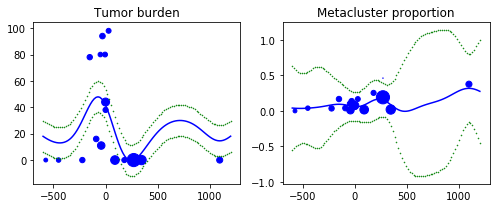

In [869]:
# make a plot
sizes = cluster_sizes.numpy()/50

# time points as numpy array
new_times = new_y.numpy()

# means
tumor_mean = new_tumor.numpy()
metacluster_mean = new_metacluster.numpy()

# plus or minus standard deviation
tumor_std = torch.diag(cov_tumor).numpy()**0.5
metacluster_std = torch.diag(cov_metacluster).numpy()**0.5

# make plots
fig, ax = plt.subplots(1,2, figsize=(7,3), tight_layout=True)

# plot tumor
ax[0].plot(new_times, tumor_mean, "b-")
ax[0].scatter(y.numpy(), tumorburden.numpy(), s=sizes, c="b")
ax[0].scatter(new_times, tumor_mean + tumor_std, c="g", s=0.3)
ax[0].scatter(new_times, tumor_mean - tumor_std, c="g", s=0.3)
ax[0].set_title("Tumor burden")

# plot tumor
ax[1].plot(new_times, metacluster_mean, "b-")
ax[1].scatter(y.numpy(), metacluster.numpy(), s=sizes, c="b")
ax[1].scatter(new_times, metacluster_mean + metacluster_std, c="g", s=0.3)
ax[1].scatter(new_times, metacluster_mean - metacluster_std, c="g", s=0.3)
ax[1].set_title("Metacluster proportion")